Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...


C:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'build' took 1.636772 s


'compile' took 4.795555 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.99e-03, 1.96e-04, 5.03e-01]    [1.99e-03, 1.96e-04, 5.03e-01]    []  
1000      [3.98e-02, 4.75e-04, 5.13e-02]    [3.98e-02, 4.75e-04, 5.13e-02]    []  
2000      [2.97e-02, 3.01e-05, 4.17e-02]    [2.97e-02, 3.01e-05, 4.17e-02]    []  
3000      [1.82e-02, 1.40e-04, 1.00e-02]    [1.82e-02, 1.40e-04, 1.00e-02]    []  
4000      [9.70e-03, 8.01e-05, 5.84e-03]    [9.70e-03, 8.01e-05, 5.84e-03]    []  
5000      [2.80e-03, 1.16e-05, 2.86e-03]    [2.80e-03, 1.16e-05, 2.86e-03]    []  
6000      [1.92e-03, 4.32e-06, 2.28e-03]    [1.92e-03, 4.32e-06, 2.28e-03]    []  
7000      [1.61e-03, 4.51e-06, 1.99e-03]    [1.61e-03, 4.51e-06, 1.99e-03]    []  
8000      [1.52e-03, 6.56e-06, 1.92e-03]    [1.52e-03, 6.56e-06, 1.92e-03]    []  
9000      [1.15e-03, 4.47e-06, 1.17e-03]    [1.15e-03, 4.47e-06, 1.17e-03]    []  
10000  

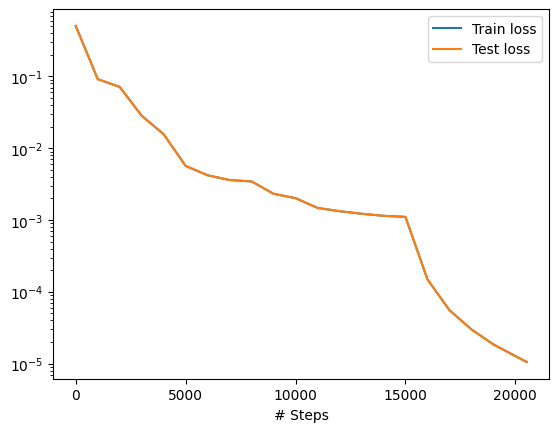

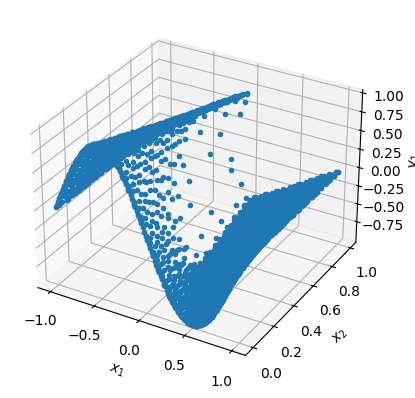

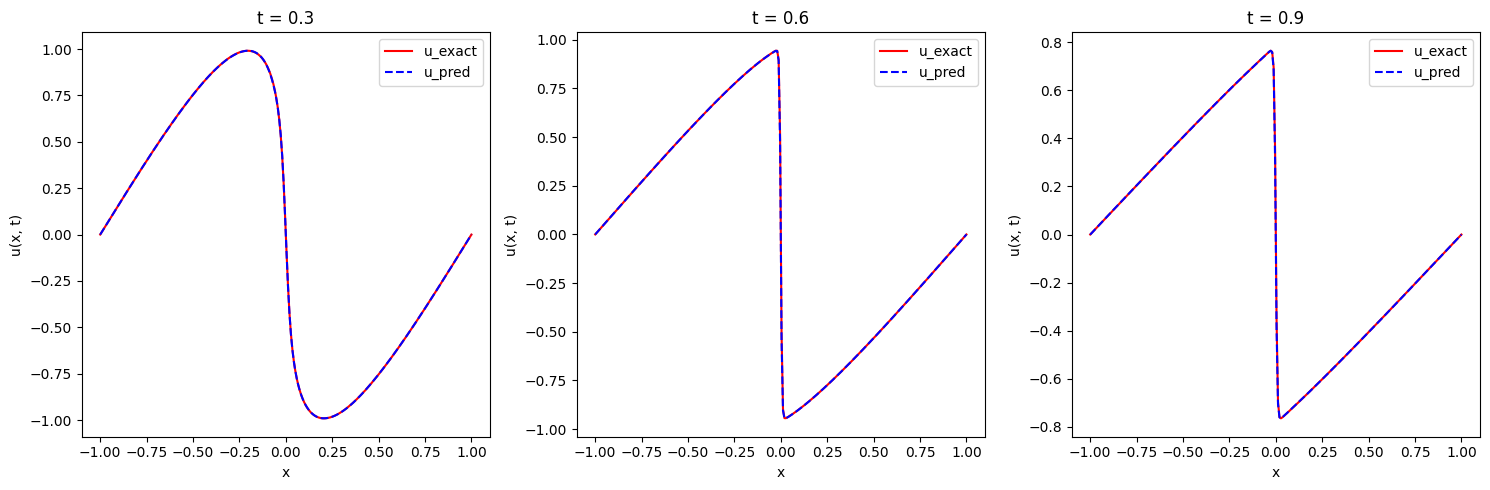

Mean residual: 0.0031084714
L2 relative error: 0.004348329633978998


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Function to generate test data
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# Define PDE, geometry, boundary conditions, etc.
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3+ [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Generate test data and predict using the trained model
X, y_true = gen_testdata()
y_pred = model.predict(X)

# Plotting the results at three different time points
time_points = [0.3, 0.6, 0.9]
x = X[:, 0]
t = X[:, 1]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, tp in enumerate(time_points):
    mask = np.isclose(t, tp)
    x_tp = x[mask]
    u_tp_pred = y_pred[mask]
    u_tp_true = y_true[mask]
    
    axs[i].plot(x_tp, u_tp_true, 'r-', label='u_exact')
    axs[i].plot(x_tp, u_tp_pred, 'b--', label='u_pred')
    axs[i].set_title(f't = {tp}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('u(x, t)')
    axs[i].legend()

plt.tight_layout()
plt.show()

# Optionally, print metrics
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))
